In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import random
import gc
import os
import datetime
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

today = datetime.datetime.now().strftime('%Y%m%d')

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

Half_Half_LightGBM Training

In [2]:
class Trainer:
    def __init__(self, importance_df, model_type='lgb', use_feature_num=None):
        self.model_type = model_type
        
        if use_feature_num is not None:
            self.features = importance_df['feature'][:use_feature_num].tolist()
        else:
            self.features = None
            
    def train_half(self, X_train, y_train, params, num_boost_round, early_stopping_rounds, verbose=200):
        
        if self.features is None:
            self.features = X_train.columns
            
        self.features = [c for c in self.features if c not in ['M']]
            
        self.X_train = X_train[self.features]
        self.y_train = y_train
        
        if self.model_type == 'lgb':
            print('LightGBM Model Creating...')
            d_half_1 = lgb.Dataset(self.X_train[:int(self.X_train.shape[0] / 2)], 
                                   label=self.y_train[:int(X_train.shape[0] / 2)])
            d_half_2 = lgb.Dataset(self.X_train[int(self.X_train.shape[0] / 2):], 
                                   label=self.y_train[int(X_train.shape[0] / 2):])

            print("Building model with first half and validating on second half:")
            self.model_1 = lgb.train(params, train_set=d_half_1, num_boost_round=num_boost_round, 
                                     valid_sets=[d_half_1, d_half_2], verbose_eval=verbose, 
                                     early_stopping_rounds=early_stopping_rounds)
            
            print('')
            print("Building model with second half and validating on first half:")
            self.model_2 = lgb.train(params, train_set=d_half_2, num_boost_round=num_boost_round, 
                                     valid_sets=[d_half_2, d_half_1], verbose_eval=verbose, 
                                     early_stopping_rounds=early_stopping_rounds)
            
        elif self.model_type == 'cat':
            print('CatBoost Model Creating...')
            cat_features_index = np.where(self.X_train.dtypes == 'category')[0]
            d_half_1 = Pool(self.X_train[:int(self.X_train.shape[0] / 2)], 
                            label=self.y_train[:int(X_train.shape[0] / 2)],
                            cat_features=cat_features_index)
            d_half_2 = Pool(self.X_train[int(self.X_train.shape[0] / 2):], 
                            label=self.y_train[int(X_train.shape[0] / 2):],
                            cat_features=cat_features_index)
            
            params['iterations'] = num_boost_round
            print("Building model with first half and validating on second half:")
            model_1 = CatBoostRegressor(**params)
            model_1.fit(d_half_1, eval_set=d_half_2, use_best_model=True,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
            
            print('')
            print("Building model with second half and validating on first half:")
            model_2 = CatBoostRegressor(**params)
            model_2.fit(d_half_2, eval_set=d_half_1, use_best_model=True,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
            
        
        return (self.model_1, self.model_2)
    
    def get_feature_importance(self):
        df_fimp_1 = pd.DataFrame()
        df_fimp_1["feature"] = self.X_train.columns.values
        if self.model_type == 'lgb':
            df_fimp_1["importance"] = self.model_1.feature_importance()
        elif self.model_type == 'cat':
            df_fimp_1["importance"] = self.model_1.get_feature_importance()
        df_fimp_1["half"] = 1

        df_fimp_2 = pd.DataFrame()
        df_fimp_2["feature"] = self.X_train.columns.values
        if self.model_type == 'lgb':
            df_fimp_2["importance"] = self.model_2.feature_importance()
        elif self.model_type == 'cat':
            df_fimp_2["importance"] = self.model_2.get_feature_importance()
        df_fimp_2["half"] = 2

        df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

        plt.figure(figsize=(14, int(len(self.X_train.columns) * 0.3)), facecolor='w')
        sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
        plt.title("LightGBM Feature Importance")
        plt.tight_layout()
        plt.show()
        
        del df_fimp_1, df_fimp_2, df_fimp
        gc.collect()

In [3]:
# config - LightGBM
train_pkl_path = '../input/prep_train_20191120.pkl'
test_pkl_path = '../input/prep_test_20191120.pkl'
importance_path = '../Importance/importance_20191120.csv'
model_type = 'lgb'

params = {
        'objective': 'regression',
        'boosting_type': 'gbrt',
        'metric': 'rmse',
        'n_jobs': -1,
        'learning_rate': 0.01,
        'max_bin': 255,
        'max_depth': 10,
        'num_leaves': 242,
        'colsample_bytree': 0.8659940184256816,
        'subsample': 0.8922113062563624,
        'min_data_in_leaf': 47,
        'feature_fraction': 0.852216419174993,
        'bagging_fraction': 0.42797307400289963,
        'bagging_freq': 6,
        'reg_lambda': 137.8767751523373,
        'verbose': -1,
        'seed': 42
    }

num_boost_round = 10000
early_stopping_rounds = 500
num_feature = 40
verbose = 1000

In [4]:
%%time
# Training
# Data Loading
with open(train_pkl_path, 'rb') as f:
    train = pickle.load(f)

importance_df = pd.read_csv(importance_path)
# Train Model
trainer = Trainer(importance_df=importance_df, model_type=model_type, use_feature_num=num_feature)
models = trainer.train_half(train[0], train[1], params, num_boost_round, early_stopping_rounds, verbose)

del train, importance_df
gc.collect()

with open(f'../Model/model_{today}_{trainer.model_type}_half.pkl', 'wb') as f:
    pickle.dump(models, f, protocol=4)

LightGBM Model Creating...
Building model with first half and validating on second half:
Training until validation scores don't improve for 500 rounds
[1000]	training's rmse: 0.780026	valid_1's rmse: 1.14294
[2000]	training's rmse: 0.698667	valid_1's rmse: 1.14124
Early stopping, best iteration is:
[1549]	training's rmse: 0.725874	valid_1's rmse: 1.1401

Building model with second half and validating on first half:
Training until validation scores don't improve for 500 rounds
[1000]	training's rmse: 0.781885	valid_1's rmse: 1.16107
Early stopping, best iteration is:
[1265]	training's rmse: 0.74999	valid_1's rmse: 1.16002
Wall time: 43min 47s


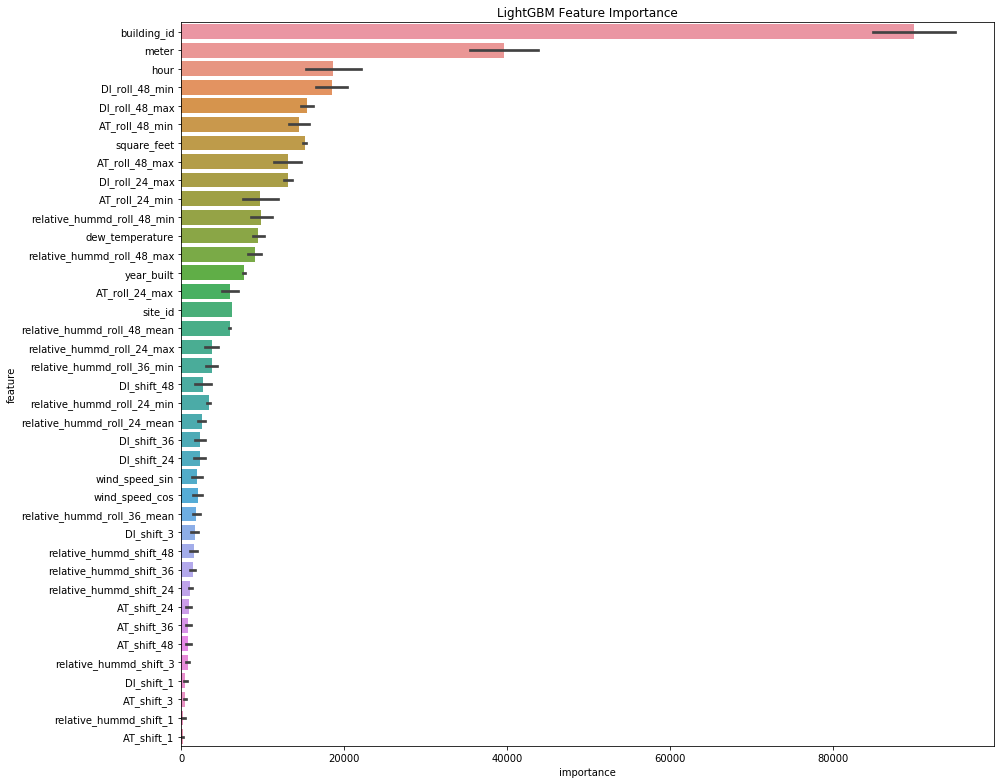

In [5]:
trainer.get_feature_importance()

Preparing test data 

Preparing test data with same features as train data.

In [14]:
%%time
# Predict & Submission
# Load Models from Pickle
with open('../Model/model_20191120_lgb_half.pkl', 'rb') as f:
    models = pickle.load(f)
importance_df = pd.read_csv(importance_path)
trainer = Trainer(importance_df=importance_df, model_type=model_type, use_feature_num=num_feature)
trainer.features = [c for c in trainer.features if c not in ['M']]

# Data Loading
with open(test_pkl_path, 'rb') as f:
    test = pickle.load(f)
    
X_test = test[0]
row_id = test[1]
del test
gc.collect()
    
if num_feature is not None:
    X_test = X_test[trainer.features]
    gc.collect()

# Set Predict values
pred = np.zeros(len(row_id))

# Prediction
for model in models:
    if trainer.model_type == 'lgb':
        pred += np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) / int(len(models))
    elif trainer.model_type == 'cat':
        pred += np.expm1(model.predict(X_test)) / int(len(models))
    
today = datetime.datetime.now().strftime('%Y%m%d')
submission = pd.DataFrame({"row_id": row_id, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv(f"../Output/submission_from_nb_{trainer.model_type}_{today}.csv", index=False)
print("DONE")

DONE
Wall time: 1h 58min 40s


In [12]:
del X_test, row_id

In [15]:
gc.collect()

44